In [1]:
import glob

import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.axes_grid1 import ImageGrid

from astropy import wcs
from astropy.io import fits
import astropy.units as u
from astropy.visualization import simple_norm
from astropy.table import QTable

from photutils.aperture import CircularAperture, CircularAnnulus
# from photutils.aperture import aperture_photometry

from astropy.nddata import Cutout2D
from astropy.stats import sigma_clipped_stats

# specific functions for this work
from helpers import get_aper_flux, disp_subimages, coords_from_mosaic

Source details

In [2]:
sourcecoords = "5:05:30.62  +52:49:54.0"   # nominal source location
# sourcecoords = "76.377584   52.830871"
sourcename = "g191b2b"
aorid = "r28510976"
aprads = [3.0, 3.0, 7.0]  # source radius, sky inner/outer radii
apcors = [1.125, 1.120, 1.135, 1.221]

Determine the source position based on default coordinates and centroiding on nearest source

ch1 76.37760202975106 52.830872204527374
ch2 76.37762298048386 52.83091092617072
ch3 76.37759482849958 52.83087496269123
ch4 76.37765764463508 52.830886002733436


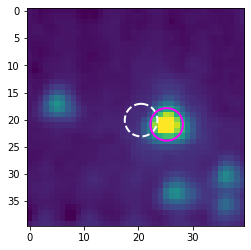

In [3]:
centers = []
for i in np.arange(1,5):
    mosfilename = glob.glob(f"data/{sourcename}/{aorid}/ch{i}/pbcd/SPITZER_I{i}_*_maic.fits")[0]
    new_center = coords_from_mosaic(sourcecoords, mosfilename, show_image=(i==1))
    centers.append(new_center)
    print(f"ch{i}", new_center.ra.degree, new_center.dec.degree)
new_center = centers[0]

Perform aperture photometry and display cutouts with the apertures used

In [4]:
allchfiles = [np.sort(glob.glob(f"data/{sourcename}/{aorid}/ch{i}/bcd/SPITZER_I{i}_*_cbcd.fits")) for i in np.arange(1, 5)]

chsfluxes = []
chscorfacs1 = []
chscorfacs2 = []
chsfiles = []
chsx = []
chsy = []
medbkgs = []
totbkgs = []
for k, allfiles in enumerate(allchfiles):
    sfluxes = []
    corfac1 = []
    corfac2 = []
    medbkg = []
    totbkg = []
    files = []
    x = []
    y = []
    for cfilename in allfiles:
        hdul = fits.open(cfilename)
        image = hdul[0].data
        w = wcs.WCS(hdul[0].header)

        # pixscales = np.absolute([hdul[0].header["PXSCAL1"], hdul[0].header["PXSCAL2"]]) / 3600.
        # pix_area_sr = (pixscales[0]*pixscales[1])*((np.pi/180.0))**2
        pix_area_sr = w.proj_plane_pixel_area().to(u.sr).value
        conv_fac = 1e9*pix_area_sr  # convert from MJy/sr to mJy/pixel  
        image *= conv_fac
        
        center_pix = new_center.to_pixel(w)
        isize = image.shape
        if (0 < center_pix[0] < isize[0]) & (0 < center_pix[1] < isize[1]):
            aperture = CircularAperture(center_pix, r=aprads[0])
            annulus_aperture = CircularAnnulus(center_pix, r_in=aprads[1], r_out=aprads[2])
            cflux = get_aper_flux(image, aperture, annulus_aperture, center_pix, k)
            sfluxes.append(cflux[0]*apcors[k])
            corfac1.append(cflux[1])
            corfac2.append(cflux[2])
            medbkg.append(cflux[3])
            totbkg.append(cflux[4]*apcors[k]*cflux[1]*cflux[2])  # apply same corrections as aperture fluxes
            files.append(cfilename)
            x.append(center_pix[0])
            y.append(center_pix[1])
    chsfluxes.append(sfluxes)
    chscorfacs1.append(corfac1)
    chscorfacs2.append(corfac2)
    medbkgs.append(medbkg)
    totbkgs.append(totbkg)
    chsfiles.append(files)
    chsx.append(x)
    chsy.append(y)

ch1 2.0226088211362927 mJy 0.03189605827722094 mJy 0.0041525130916922875 mJy 487.08066090937047 0.14266308953724485 mJy 59
ch2 1.278686534022449 mJy 0.02490027714054482 mJy 0.003241739964048233 mJy 394.4445107267782 0.12617101719235002 mJy 59
ch3 0.7942925498140537 mJy 0.06294613635716988 mJy 0.00819488894279039 mJy 96.92535864233373 1.9147041640780593 mJy 59
ch4 0.41682835203238083 mJy 0.06897243643430012 mJy 0.009385959754476828 mJy 44.40977405997995 5.073470115979838 mJy 54
<SkyCoord (ICRS): (ra, dec) in deg
    (76.3776, 52.83087)>


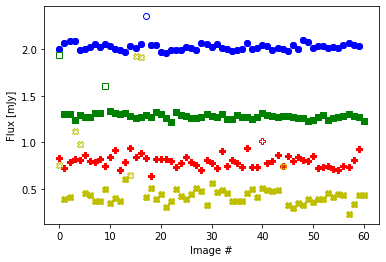

In [5]:
from astropy.stats import sigma_clip

aphot = QTable(names=("channel", "flux", "stddev", "mean_stddev", "SNR", "mean_bkg", "npts"),
               dtype=("int", "float", "float", "float", "float", "float", "int"),
               units=("", "mJy", "mJy", "mJy", "", "mJy", ""))

ptype = ['bo', 'gs', 'rP', 'yX']
chfiltered = []
np.set_printoptions(precision=5)
for i, sfluxes in enumerate(chsfluxes):
    plt.plot(np.arange(len(sfluxes)), sfluxes, ptype[i], fillstyle="none")

    filtered_data = sigma_clip(sfluxes, sigma=3, maxiters=5, masked=True)
    chfiltered.append(filtered_data)
 
    # make and output an astropy table
    ophot = QTable()
    nfluxes = len(sfluxes)
    ophot["AOR"] = [aorid] * nfluxes
    ophot["channel"] = [i+1] * nfluxes
    ophot["pix_x"] = chsx[i]
    ophot["pix_y"] = chsy[i]
    ophot["flux"] = sfluxes * u.mJy
    ophot["pointgaincor"] = chscorfacs1[i]
    ophot["pixelphasecor"] = chscorfacs2[i]
    ophot["median_bkg"] = medbkgs[i] * u.mJy
    ophot["total_bkg"] = totbkgs[i] * u.mJy
    ophot["mask"] = filtered_data.mask
    ophot["filename"] = chsfiles[i]
    ophot.write(f"data/{sourcename}/{sourcename}_{aorid}_ch{i+1}_phot.dat", format="ipac", overwrite=True)

    plt.plot(np.arange(len(sfluxes)), filtered_data, ptype[i])

    mean = np.mean(filtered_data) * u.mJy
    stddev = np.std(filtered_data) * u.mJy
    stdmean = stddev / np.sqrt(len(filtered_data[~filtered_data.mask]))
    tbkgs = np.ma.masked_array(totbkgs[i], mask=filtered_data.mask)
    meanbkg = np.mean(tbkgs) * u.mJy
    print(f"ch{i+1}", mean, stddev, stdmean, mean/stdmean, meanbkg, len(filtered_data[~filtered_data.mask]))
    aphot.add_row([i+1, mean, stddev, stdmean, mean/stdmean, meanbkg, len(filtered_data[~filtered_data.mask])])

aphot.write(f"data/{sourcename}/{sourcename}_{aorid}_ave_phot.dat", format="ipac", overwrite=True)
               
plt.xlabel("Image #")
plt.ylabel("Flux [mJy]")

print(new_center)

Display cutouts of each image showing the apertures used

Red sky annulii indicate measurements that were sigma clip rejected

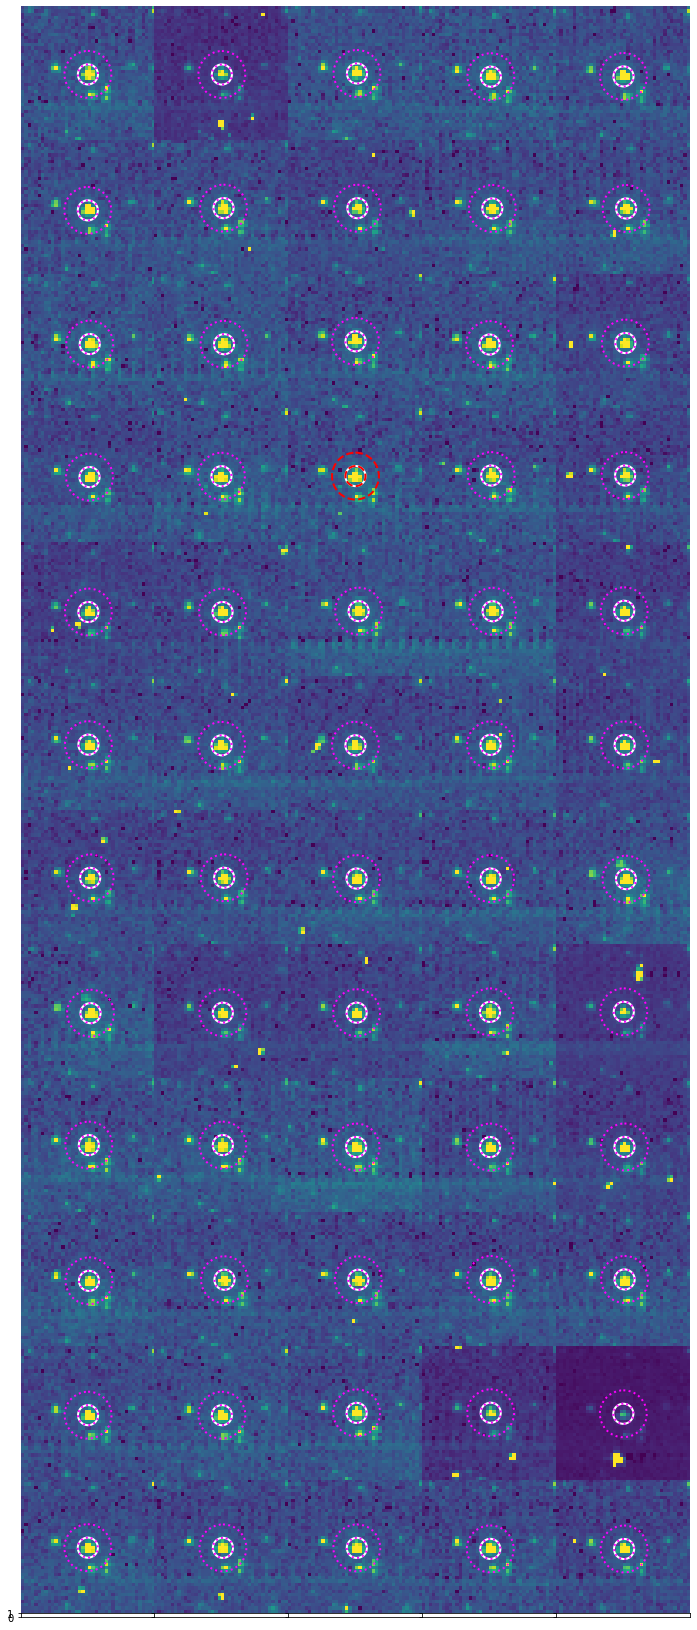

In [6]:
disp_subimages(allchfiles[0], chfiltered[0], aprads, new_center)

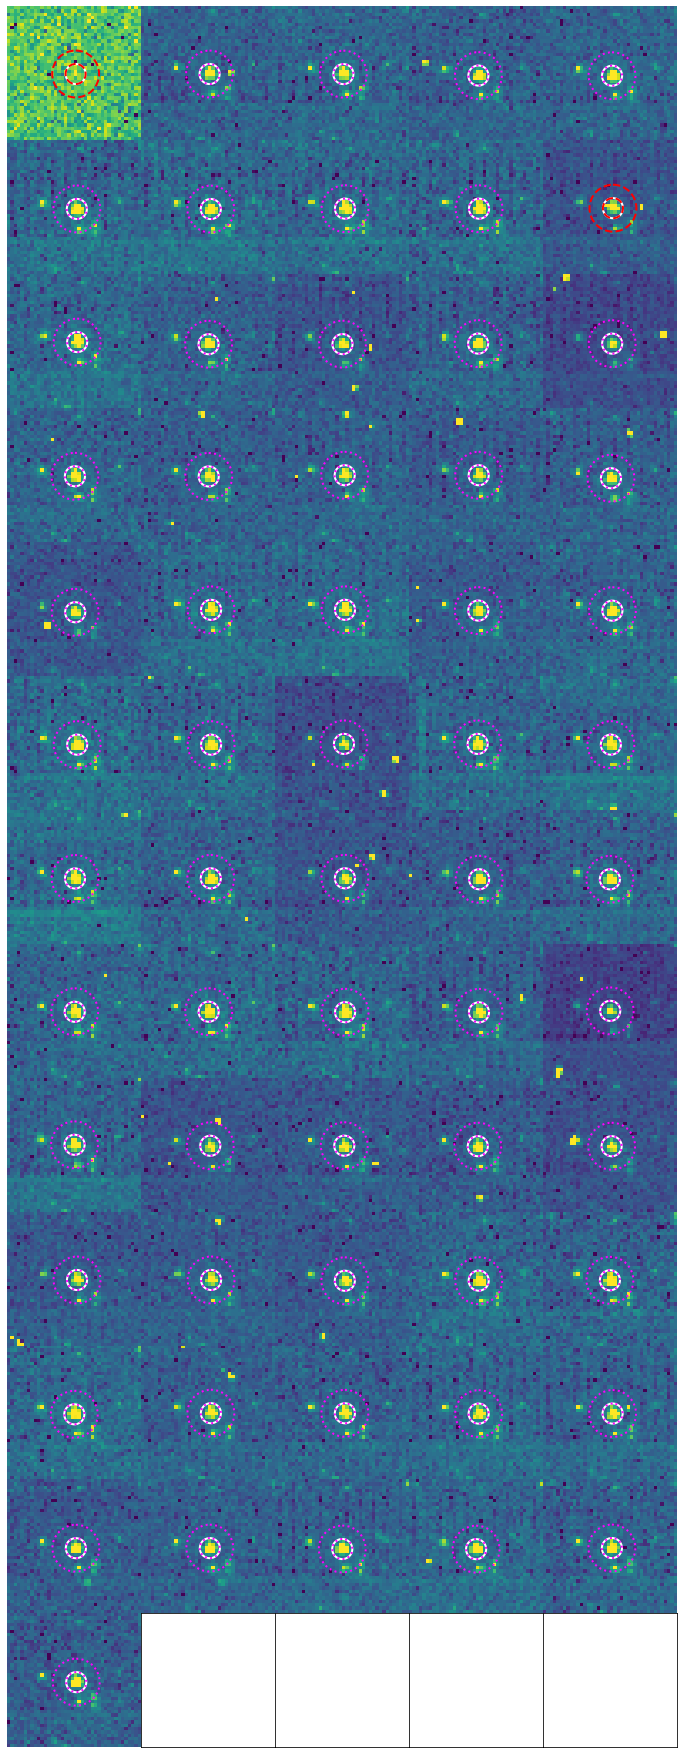

In [7]:
disp_subimages(allchfiles[1], chfiltered[1], aprads, new_center)

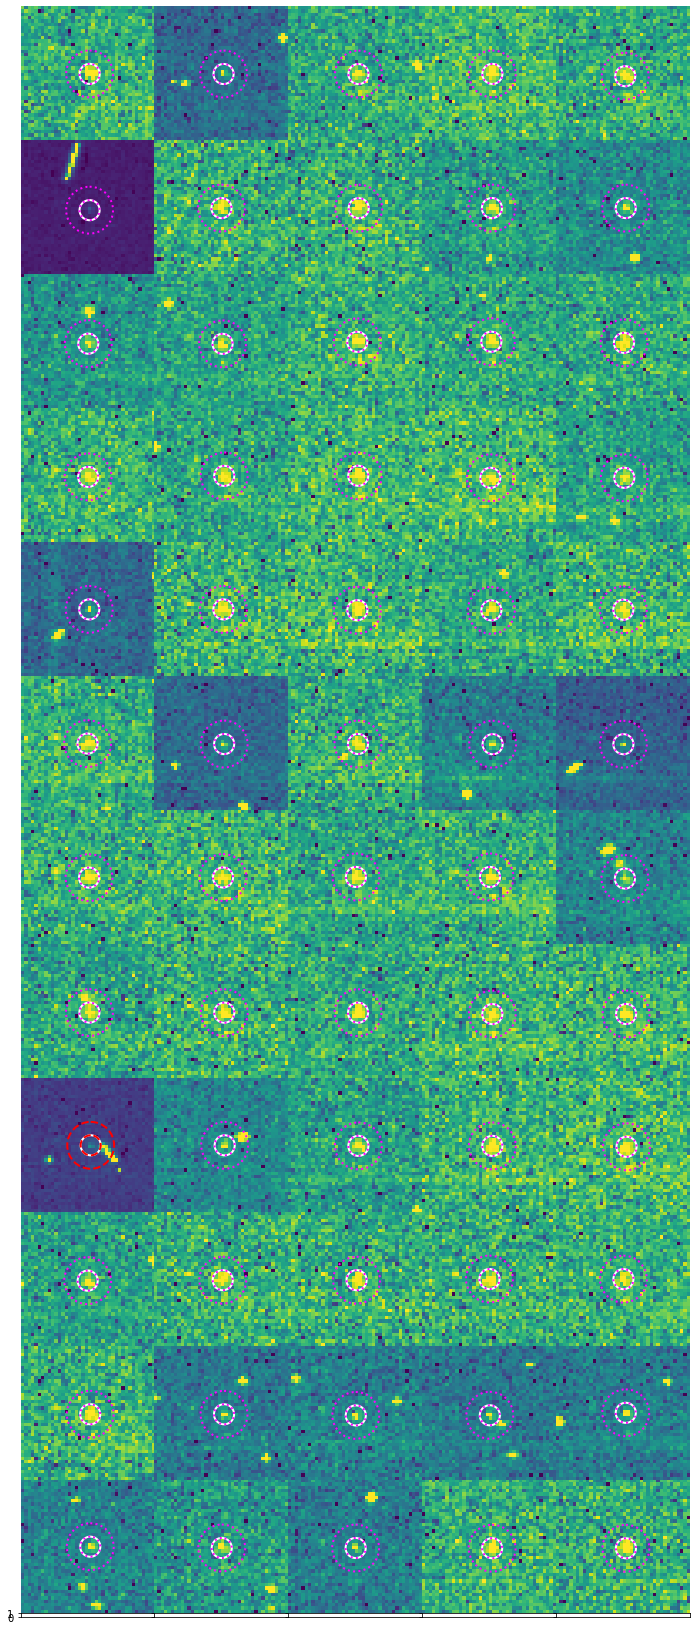

In [8]:
disp_subimages(allchfiles[2], chfiltered[2], aprads, new_center)

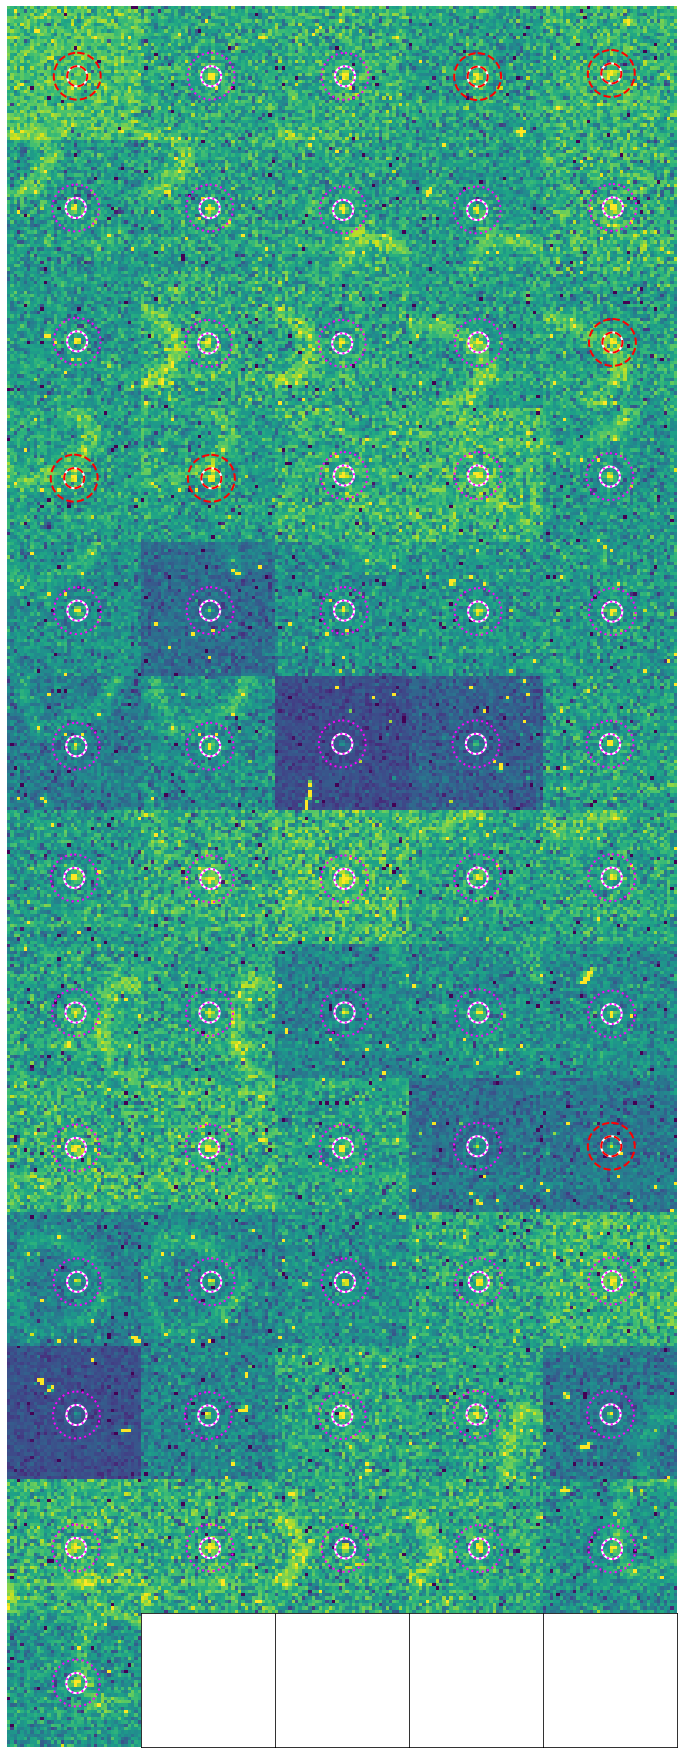

In [9]:
disp_subimages(allchfiles[3], chfiltered[3], aprads, new_center)